In [1]:
run_folder = 'tracks_symlink/desk/routes/I/runs/0'
              

## Imports and Helpers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
import subprocess
%matplotlib inline

In [3]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [4]:
def table_tag(fragments, columns):
    column = 1
    s = '<table><tr>'
    for fragment in fragments:
        s = s + '<td>' + fragment + '</td>'
        column = column + 1
        if column > columns:
            s = s + '</tr><tr>'
            column = 1
    s = s + '</td></tr></table>'
    return s

In [5]:
def big_figure():
    fig = plt.figure()
    fig.set_size_inches(w=15,h=10)
    return fig

## Settings

In [6]:
front_meters_per_odometer_tick = 0.002528
rear_meters_per_odometer_tick = 0.002528
front_wheelbase_width_in_meters = 0.2413
rear_wheelbase_width_in_meters = 0.2667
wheelbase_length_in_meters = 0.33655

## Analysis

In [7]:
route_folder = os.path.dirname(os.path.dirname(run_folder)) # two folders up
route_folder

'tracks_symlink/desk/routes/I'

In [8]:
print(subprocess.check_output('cat '+run_folder+"/config.json",shell=True).decode('utf-8'))


track_name = desk
route_name = I
max_a = 0.5
max_v = 1
steering_k_p = 80
steering_k_i = 0
steering_k_d = 5
v_k_p = 6
v_k_i = 0
v_k_d = 0.5
slip_rate = 0.2
slip_slop = 0.5
t_ahead = 0.3
d_ahead = 0.1
k_smooth = 0.4
prune_max = 0.5
prune_tolerance = 0.02
capture_video = 0
crash_recovery = 0
optimize_velocity = 1



In [9]:
# Create / Show videos


video_tags = []
for f in ['video_left','video_right']:
    mp4_path = os.path.join(run_folder,f+'.mp4')
    if not os.path.exists(mp4_path):
        avi_path = os.path.join(run_folder,f+'.avi')
        if os.path.exists(avi_path):
            s = 'ffmpeg -i "{0}" -vcodec h264 -acodec copy "{1}"'.format(avi_path,mp4_path)
            subprocess.call(s,shell=True)
    if os.path.exists(mp4_path):
        video_tags.append(video_tag(mp4_path,title=f))
    else:
        print("couldn't find ", mp4_path)
display.display(display.HTML(table_tag(video_tags, columns=2)))


couldn't find  tracks_symlink/desk/routes/I/runs/0/video_left.mp4
couldn't find  tracks_symlink/desk/routes/I/runs/0/video_right.mp4


In [10]:
tdt = pd.read_csv(os.path.join(run_folder,'td.csv'),parse_dates=(['timestamp']))


In [11]:
tdt.columns

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl_a',
       'odo_fl_a_us', 'odo_fl_b', 'odo_fl_b_us', 'odo_fl_ab_us', 'odo_fr_a',
       'odo_fr_a_us', 'odo_fr_b', 'odo_fr_b_us', 'odo_fr_ab_us', 'odo_bl_a',
       'odo_bl_a_us', 'odo_bl_b', 'odo_bl_b_us', 'odo_bl_ab_us', 'odo_br_a',
       'odo_br_a_us', 'odo_br_b', 'odo_br_b_us', 'odo_br_ab_us', 'odo_spur',
       'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax', 'ay', 'az', 'imu_calib'],
      dtype='object')

In [12]:

tdt[['odo_fl_a_us', 'odo_fl_b_us']].max(axis=1)

0       1831927299
1       1831927299
2       1831927299
3       1831927299
4       1831927299
5       1831927299
6       1831927299
7       1831927299
8       1831927299
9       1831927299
10      1831927299
11      1831927299
12      1831927299
13      1831927299
14      1831927299
15      1831927299
16      1831927299
17      1831927299
18      1837496148
19      1837507825
20      1837507825
21      1837507825
22      1837532185
23      1837542034
24      1837557634
25      1837564545
26      1837579212
27      1837585638
28      1837597470
29      1837602837
           ...    
1653    1853845886
1654    1853858378
1655    1853864982
1656    1853879252
1657    1853887092
1658    1853887092
1659    1853906258
1660    1853917358
1661    1853917358
1662    1853917358
1663    1853948075
1664    1853948075
1665    1853965200
1666    1853965200
1667    1853965200
1668    1853999969
1669    1853999969
1670    1854013737
1671    1854020639
1672    1854038832
1673    1854045476
1674    1854

In [13]:
def get_td(folder):
    td = pd.read_csv(os.path.join(folder,'td.csv'),parse_dates=(['timestamp']))
    td.t = (td.ms - td.ms.values[0])/1000.
    
        
    #generate some extra columns
    for p in ['fl','fr','bl','br']:
        if not 'odo_'+p in td.columns:
            td['odo_'+p] = td['odo_'+p+'_a'] + td['odo_'+p+'_b']
            td['odo_'+p+"_us"] = tdt[['odo_'+p+'_a_us', 'odo_'+p+'_b_us']].max(axis=1)
        td[p] = td['odo_'+p] - td['odo_'+p][0]

    # create td.heading from yaw, represents total turn angle from start
    dy = td.yaw.diff()
    td.heading = np.cumsum(dy + 360*(dy<-190)-360*(dy>190))
    
    # create center wheels
    td.fc = (td.fl+td.fr)/2. # front center
    td.bc = (td.bl+td.br)/2. # back center
    return td


In [14]:
!pwd

/home/brian/car/notebooks


In [15]:
route = get_td(route_folder)
run = get_td(run_folder)
print(run.columns)

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl_a',
       'odo_fl_a_us', 'odo_fl_b', 'odo_fl_b_us', 'odo_fl_ab_us', 'odo_fr_a',
       'odo_fr_a_us', 'odo_fr_b', 'odo_fr_b_us', 'odo_fr_ab_us', 'odo_bl_a',
       'odo_bl_a_us', 'odo_bl_b', 'odo_bl_b_us', 'odo_bl_ab_us', 'odo_br_a',
       'odo_br_a_us', 'odo_br_b', 'odo_br_b_us', 'odo_br_ab_us', 'odo_spur',
       'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax', 'ay', 'az', 'imu_calib',
       'odo_fl', 'odo_fl_us', 'fl', 'odo_fr', 'odo_fr_us', 'fr', 'odo_bl',
       'odo_bl_us', 'bl', 'odo_br', 'odo_br_us', 'br'],
      dtype='object')


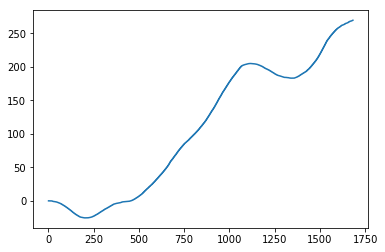

In [16]:
plt.plot(run.heading)

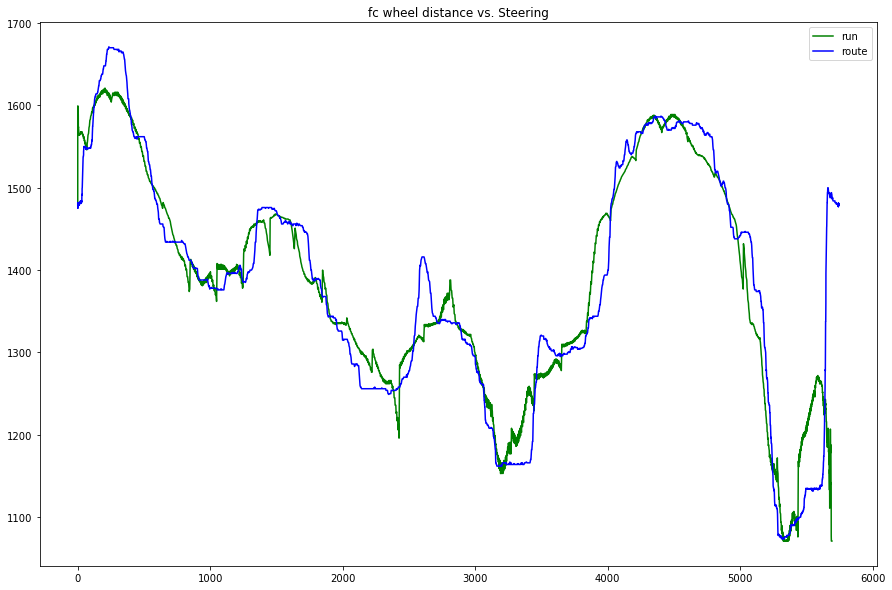

In [17]:
big_figure()
plt.title('fc wheel distance vs. Steering')
plt.plot(run.fc,run.str,color='g',label='run')
plt.plot(route.fc,route.str,color='b',label='route')
plt.legend();


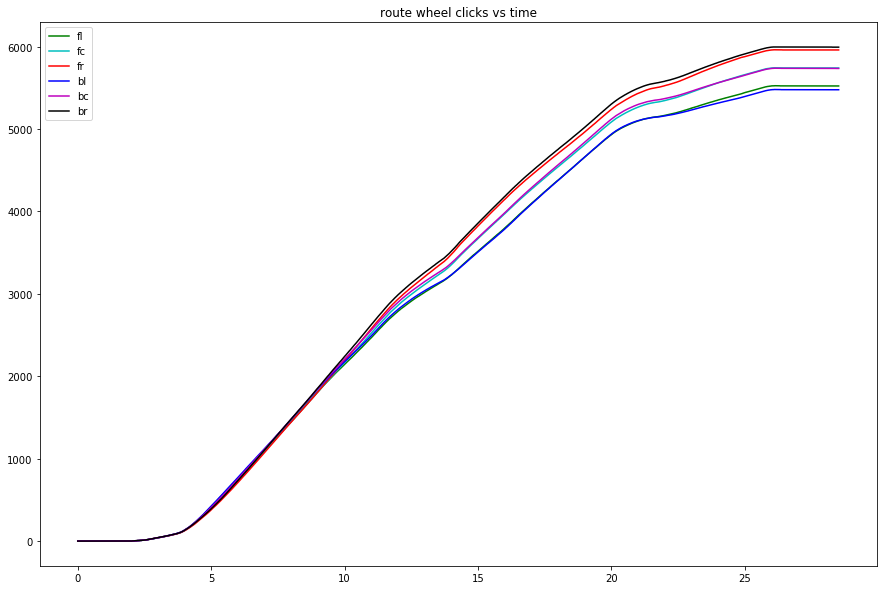

In [18]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)


plt.title('route wheel clicks vs time')
plt.plot(route.t,route.fl,color='g',label='fl')
plt.plot(route.t,route.fc,color='c', label='fc')
plt.plot(route.t,route.fr,color='r', label='fr')

plt.plot(route.t,route.bl,color='b', label='bl')
plt.plot(route.t,route.bc,color='m', label='bc')
plt.plot(route.t,route.br,color='k', label='br')
plt.legend();

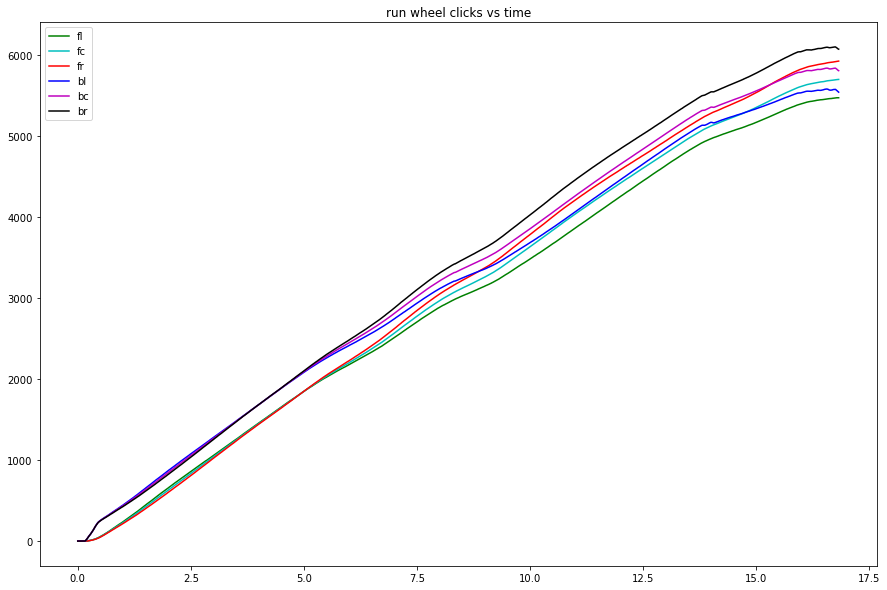

In [19]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)

ratio = 1 #.25
plt.title('run wheel clicks vs time')
plt.plot(run.t,run.fl*ratio,color='g',label='fl')
plt.plot(run.t,run.fc*ratio,color='c', label='fc')
plt.plot(run.t,run.fr*ratio,color='r', label='fr')

plt.plot(run.t,run.bl,color='b', label='bl')
plt.plot(run.t,run.bc,color='m', label='bc')
plt.plot(run.t,run.br,color='k', label='br')
plt.legend();

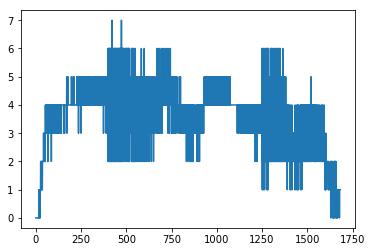

In [20]:
plt.plot(np.abs(np.diff(run.odo_fr,n=1)))

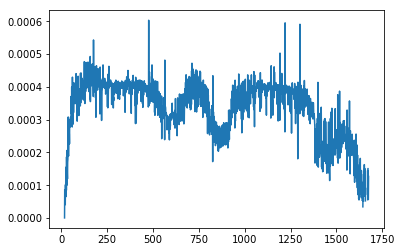

In [21]:
le = np.seterr(divide = 'ignore')
with np.errstate(invalid='ignore', divide='ignore'):
    plt.plot(np.divide(np.diff(run.odo_fl,n=1).astype(np.float),np.diff(run.odo_fl_us,n=1).astype(float)))
#np.seterr(le)

In [22]:
class KalmanFilter:
    def __init__(self, mean, variance):
        self.mean = float(mean)
        self.variance = float(variance)
    def measure(self,mean,variance):
        self.mean = (self.variance*float(mean)+self.mean*variance)/(self.variance+float(variance))
        self.variance = 1/((1/variance)+(1/self.variance))
    def update(self,distance,variance):
        self.mean += distance
        self.variance += variance                                                                    

In [23]:
def raw_v(odo,us,meters_per_odometer_tick):
    v = np.zeros_like(odo).astype(np.float)
    
    last_us = 0
    last_odo = 0
    for i in range(len(odo)):
        if last_us==0:
            v[i]==0.
            last_us = us[i]
            last_odo = odo[i]
        elif last_odo == odo[i]:
            v[i] = v[i-1]
        else:
            v[i] =(odo[i]-last_odo)*meters_per_odometer_tick / (us[i] - last_us)*1E6
            last_odo = odo[i]
            last_us = us[i]
    return v
        
    #dx = np.diff(odo).astype(np.float)*meters_per_odometer_tick
    #dt = np.diff(us).astype(np.float)/1E6
    #with np.errstate(invalid='ignore', divide='ignore'):
    #    v[1:] = np.where(dt > 0, dx/dt,0)
    #return v




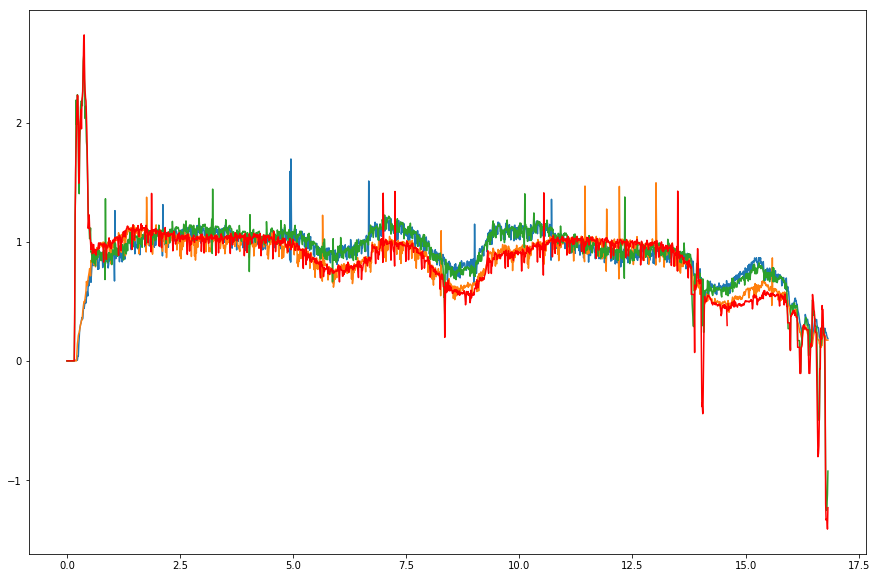

In [24]:
run.fr_v = raw_v(run.odo_fr_a,run.odo_fr_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_fr_b,run.odo_fr_b_us, front_meters_per_odometer_tick)
run.fl_v = raw_v(run.odo_fl_a,run.odo_fl_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_fl_b,run.odo_fl_b_us, front_meters_per_odometer_tick)
run.br_v = raw_v(run.odo_br_a,run.odo_br_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_br_b,run.odo_br_b_us, front_meters_per_odometer_tick)
run.bl_v = raw_v(run.odo_bl_a,run.odo_bl_a_us, front_meters_per_odometer_tick)+raw_v(run.odo_bl_b,run.odo_bl_b_us, front_meters_per_odometer_tick)

big_figure()
plt.plot(run.t, run.fr_v)
plt.plot(run.t, run.fl_v)
plt.plot(run.t, run.br_v)
plt.plot(run.t, run.bl_v,color='red')


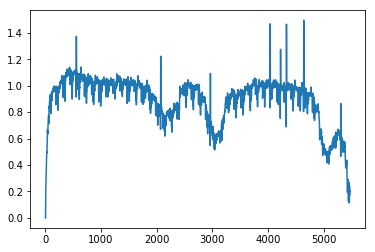

In [25]:
plt.plot(run.fl,run.fl_v)
    

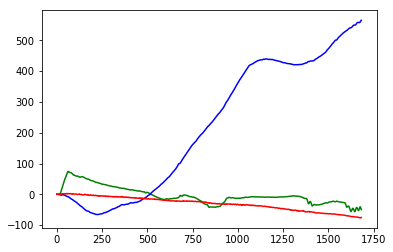

In [26]:
plt.plot(np.cumsum(run.ax),color='green')
plt.plot(np.cumsum(run.ay),color='blue')
plt.plot(np.cumsum(run.az),color='red')

In [27]:
def kalman_v(ax,vraw,measure_variance=0.1**2):
    f = KalmanFilter(0,0)
    k_v = []
    for i,v in enumerate(vraw):
        f.update(0.01*ax[i],0.01**2)
        f.measure(v,measure_variance)
        k_v.append(f.mean)
    return np.array(k_v)


In [28]:
run.fl_kv = kalman_v(run.ax,run.fl_v)
run.fr_kv = kalman_v(run.ax,run.fr_v)
run.bl_kv = kalman_v(run.ax,run.bl_v)
run.br_kv = kalman_v(run.ax,run.br_v)

In [29]:
run.fc_kv = (run.fl_kv+run.fr_kv)/2
run.fc_v =( run.fl_v+run.fr_v)/2

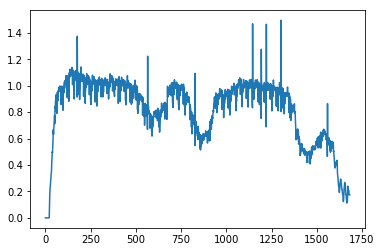

In [30]:
plt.plot(run.fl_v)

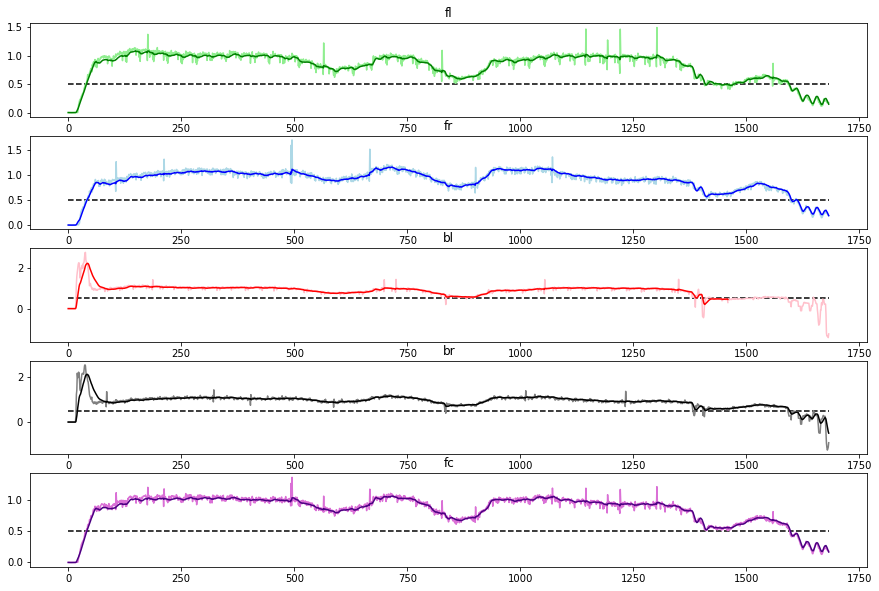

In [31]:
v_line = 0.5

big_figure()
plt.subplot(5,1,1)
plt.title('fl')
plt.plot(run.fl_v,color='lightgreen')
plt.plot(run.fl_kv,color='green')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,2)
plt.title('fr')
plt.plot(run.fr_v,color='lightblue')
plt.plot(run.fr_kv,color='blue')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,3)
plt.title('bl')
plt.plot(run.bl_v,color='pink')
plt.plot(run.bl_kv,color='red')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,4)
plt.title('br')
plt.plot(run.br_v,color='gray')
plt.plot(run.br_kv,color='black')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

plt.subplot(5,1,5)
plt.title('fc')
plt.plot(run.fc_v,color='orchid')
plt.plot(run.fc_kv,color='indigo')
plt.hlines(xmin=0,xmax=len(run.t),y=v_line,linestyles='dashed')

1445


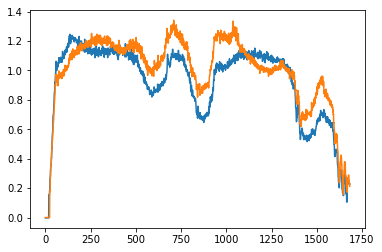

In [32]:
plt.plot(1/run.odo_fl_ab_us*1800)
plt.plot(1/run.odo_fr_ab_us*1800)
#plt.plot(1/run.odo_bl_ab_us)*1800
#plt.plot(1/run.odo_br_ab_us*1800)

print(min(abs(run.odo_fl_ab_us)))

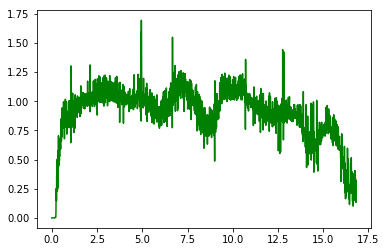

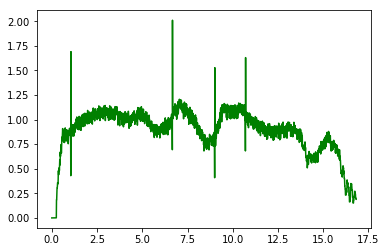

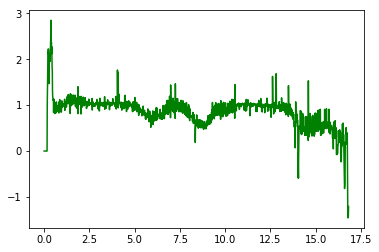

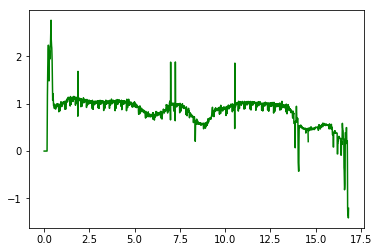

In [33]:
plt.figure()
plt.plot(run.t,raw_v(run.odo_fr,run.odo_fr_us,front_meters_per_odometer_tick),color='green')
plt.figure()
plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,2*front_meters_per_odometer_tick),color='green')
#plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,front_meters_per_odometer_tick*2),color='blue')
plt.figure()
plt.plot(run.t,raw_v(run.odo_bl,run.odo_bl_us,front_meters_per_odometer_tick),color='green')
plt.figure()
plt.plot(run.t,raw_v(run.odo_bl_a,run.odo_bl_a_us,2*front_meters_per_odometer_tick),color='green')


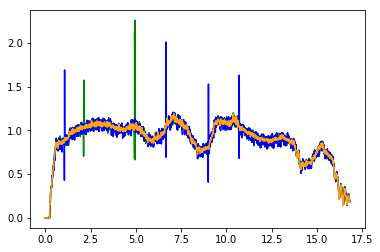

In [34]:
plt.plot(run.t,raw_v(run.odo_fr_b,run.odo_fr_b_us,front_meters_per_odometer_tick*2),color='green')
plt.plot(run.t,raw_v(run.odo_fr_a,run.odo_fr_a_us,front_meters_per_odometer_tick*2),color='blue')
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='orange')

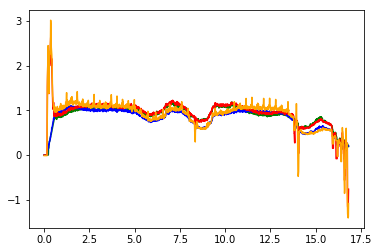

In [35]:
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='green')
plt.plot(run.t, 1/run.odo_fl_ab_us*1600,color='blue')
plt.plot(run.t, 1/run.odo_br_ab_us*1600,color='red')
plt.plot(run.t, 1/run.odo_bl_ab_us*1600,color='orange')

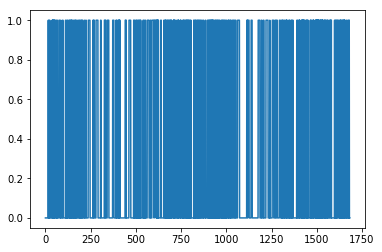

In [36]:
plt.plot(run.odo_bl_a - run.odo_bl_b)

In [37]:
def diff_n(v,n=1):
    rv = np.zeros_like(v,dtype=np.float)
    rv[n:] = np.subtract(v[n:],v[0:-n])
    return rv

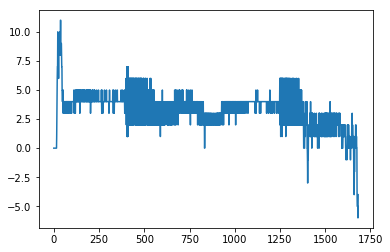

In [38]:
#plt.plot(run.t,raw_v(run.odo_bl_b,run.odo_bl_b_us,front_meters_per_odometer_tick*2),color='green')
#plt.plot(run.t,raw_v(run.odo_bl_a,run.odo_bl_a_us,front_meters_per_odometer_tick*2),color='blue')
#plt.plot(run.t, max(1/run.odo_bl_ab_us*1600,50),color='orange')
plt.plot(diff_n(run.odo_bl,1))


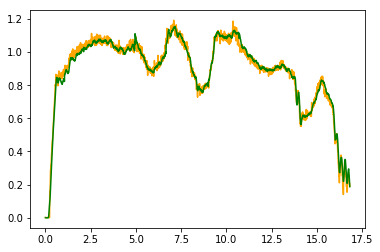

In [39]:
plt.plot(run.t, 1/run.odo_fr_ab_us*1600,color='orange')
plt.plot(run.t ,run.fr_kv, color='green')

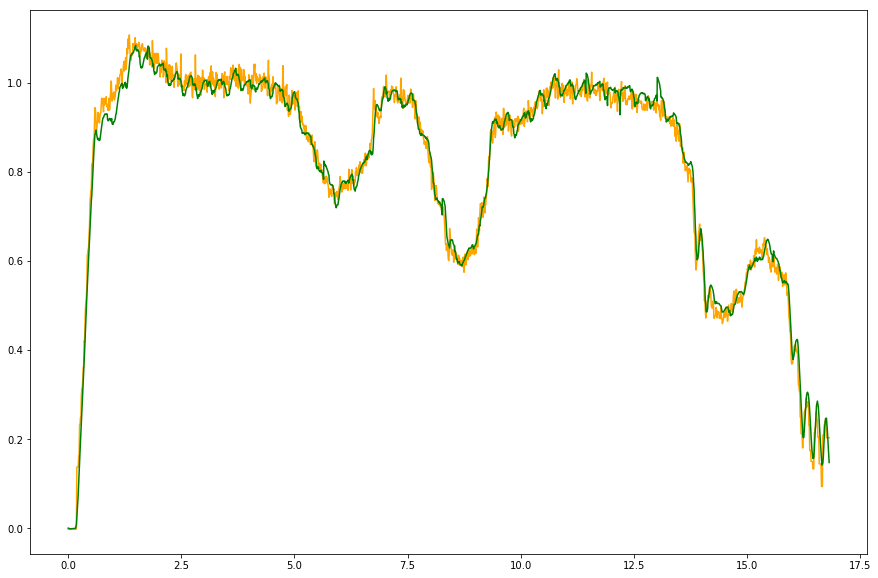

In [40]:
big_figure()
plt.plot(run.t, 1/run.odo_fl_ab_us*1600,color='orange')
plt.plot(run.t ,run.fl_kv, color='green')

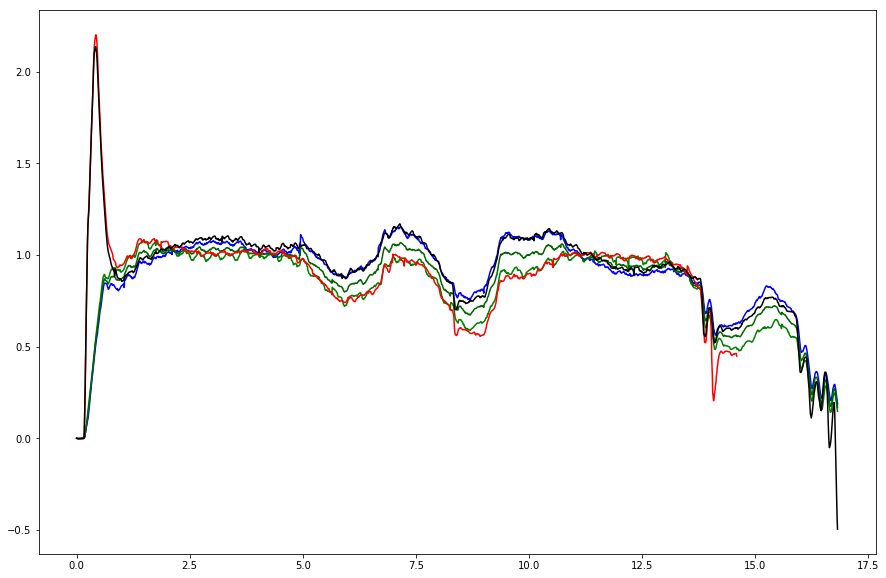

In [41]:
big_figure()
#plt.subplot(2,1,1)
plt.plot(run.t ,run.fl_kv, color='green')
plt.plot(run.t, run.fr_kv, color='blue')
plt.plot(run.t, run.fc_kv, color='darkgreen')
#plt.subplot(2,1,2)
plt.plot(run.t, run.bl_kv, color='red')
plt.plot(run.t, run.br_kv, color='black')


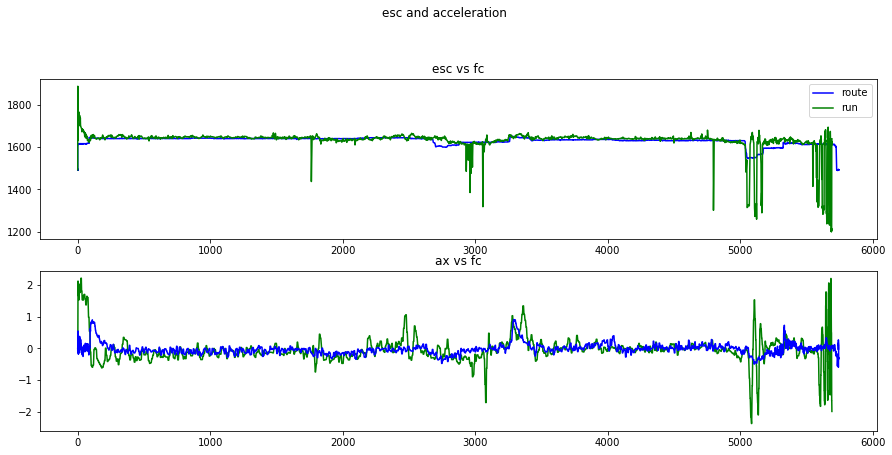

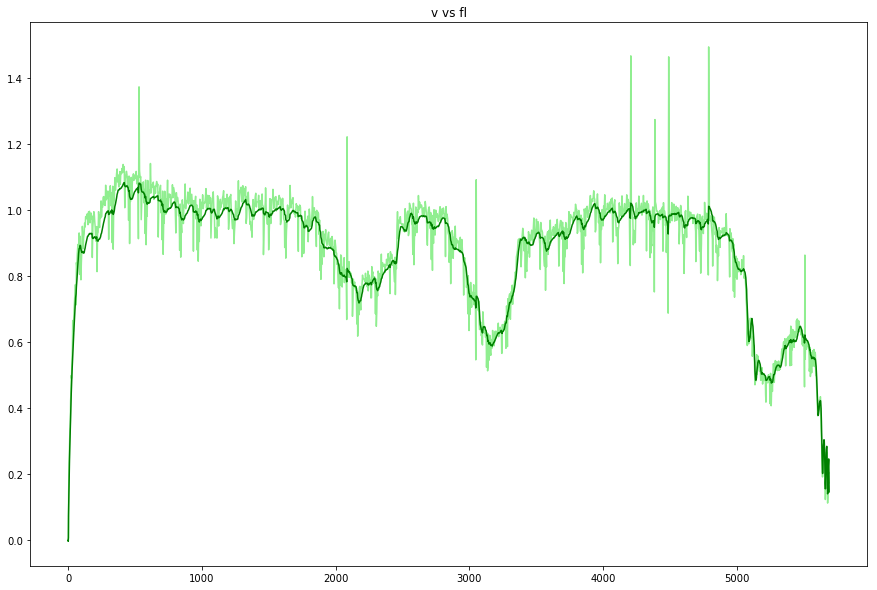

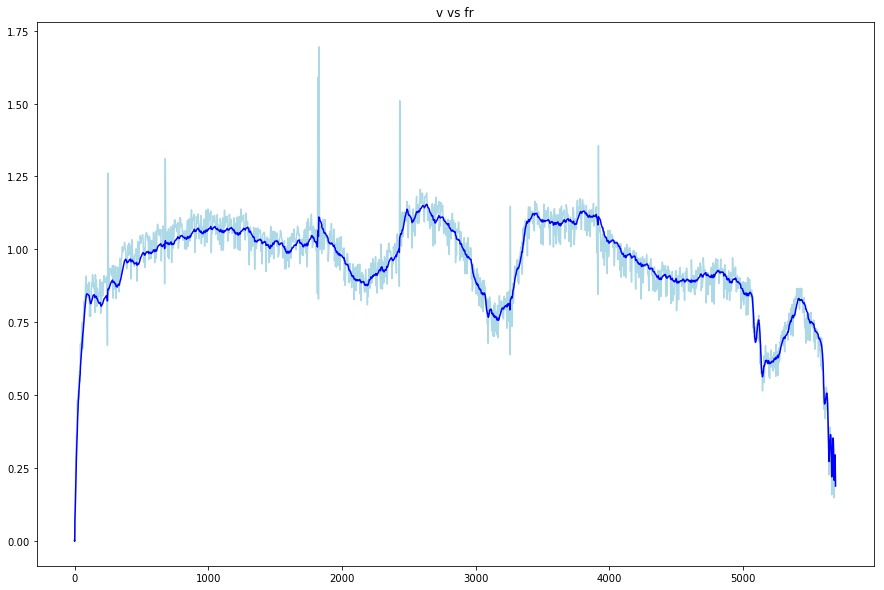

In [42]:
# research velocity
fig = big_figure()
fig.suptitle("esc and acceleration")
plt.subplot(3,1,1)
plt.plot(route.fc, route.esc, color='b',label='route')
plt.plot(run.fc, run.esc, color='g',label='run')
plt.legend()
plt.title("esc vs fc")
plt.subplot(3,1,2)
plt.title('ax vs fc')
plt.plot(run.fc, run.ax,color='g');
plt.plot(route.fc, route.ax,color='b');

big_figure()

plt.title('v vs fl')
plt.plot(run.fc, run.fl_v,color='lightgreen',label='direct');
plt.plot(run.fc, run.fl_kv,color='g',label='kalman');

big_figure()

plt.title('v vs fr')
plt.plot(run.fc, run.fr_v,color='lightblue');
plt.plot(run.fc, run.fr_kv,color='blue');

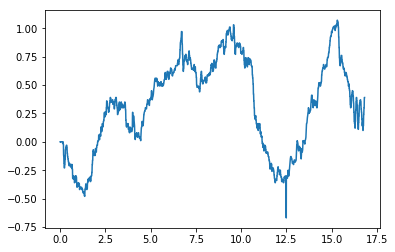

In [43]:
plt.plot(run.t,diff_n(run.heading,2));

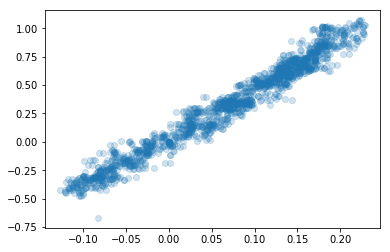

In [44]:
# How does wheel speed difference compare to turn rate?
run.dtheta=diff_n(run.heading,2)
plt.plot(run.fr_kv-run.fl_kv, run.dtheta,"o",alpha=0.2);

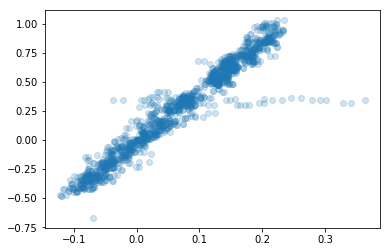

In [45]:
run.dtheta=diff_n(run.heading,2)
plt.plot(run.br_kv-run.bl_kv, run.dtheta,"o",alpha=0.2);

In [46]:
def bar_chart(d):
    '''
    plots a bar chart for dictionary d
    '''
    plt.bar(range(len(d)), d.values(), align='center')
    plt.xticks(range(len(d)), d.keys(),rotation=30,size=12)
    return plt

In [52]:
run['odo_fl_ab_us'][1000:1050]

1000    1752
1001    1746
1002    1748
1003    1763
1004    1743
1005    1749
1006    1708
1007    1697
1008    1774
1009    1753
1010    1739
1011    1733
1012    1708
1013    1720
1014    1733
1015    1754
1016    1736
1017    1667
1018    1692
1019    1711
1020    1741
1021    1722
1022    1711
1023    1694
1024    1709
1025    1700
1026    1730
1027    1722
1028    1728
1029    1694
1030    1714
1031    1685
1032    1675
1033    1671
1034    1692
1035    1677
1036    1696
1037    1699
1038    1688
1039    1654
1040    1657
1041    1630
1042    1645
1043    1643
1044    1668
1045    1654
1046    1652
1047    1678
1048    1720
1049    1686
Name: odo_fl_ab_us, dtype: int64

/home/brian/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1578: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


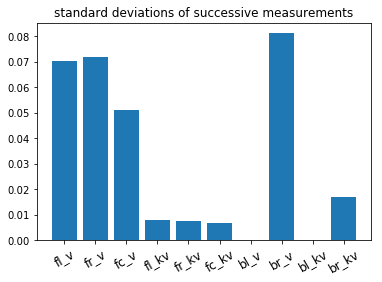

In [48]:
d = {
    'fl_v':np.std(np.diff(run.fl_v)),
    'fr_v':np.std(np.diff(run.fr_v)),
    'fc_v':np.std(np.diff(run.fc_v)),
    'fl_kv':np.std(np.diff(run.fl_kv)),
    'fr_kv':np.std(np.diff(run.fr_kv)),
    'fc_kv':np.std(np.diff(run.fc_kv)),
    'bl_v':np.std(diff_n(run.bl_v)),
    'br_v':np.std(np.diff(run.br_v)),
    'bl_kv':np.std(np.diff(run.bl_kv)),
    'br_kv':np.std(np.diff(run.br_kv)),
}
bar_chart(d);
plt.title('standard deviations of successive measurements');